 # 分類1:アヤメの判別

In [291]:
from typing import Any
import unittest
import doctest
import os
path = os.path.dirname(os.path.abspath(__file__))

import pandas as pd
import seaborn as sns

class CSVRepository:
    def __init__(self) -> None:
        pass

    def get_data(self):
        return pd.read_csv(path + '/data/iris.csv')

class SQLRepository:
    def __init__(self) -> None:
        pass

    def get_data(self):
        from sqlalchemy import create_engine
        host = 'localhost'
        port = '5432'
        db = 'test'
        username = 'root'
        password = 'root'

        engine = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}')
        return pd.read_sql_table('iris', engine)

class CategoricalData:
    def __init__(self, df, col) -> None:
        self.df = df
        self.col = col

    def show(self):
        """カテゴリーデータの値の数を確認"""
        return self.df[self.col].value_counts()

    def plot(self):
        """カテゴリーデータの値の数を棒グラフで確認"""
        return self.df[self.col].value_counts().plot(kind='bar')

    def convert(self):
        """カテゴリーデータを数値に変換"""
        from sklearn.preprocessing import LabelEncoder

        encoder = LabelEncoder()
        return encoder.fit_transform(self.df[self.col])

    def pivot(self, index,value):
        """ピボットテーブルによる集計"""
        return self.df.pivot_table(index=index, columns=self.col, values=value, aggfunc='count')

    def dummy(self):
        """ダミー変数化"""
        return pd.get_dummies(self.df, columns=[self.col])

class DataVisualization:
    def __init__(self, df) -> None:
        self.df = df

    def df_hist(self):
        """データフレームのヒストグラム表示"""
        return self.df.hist(figsize=(12, 12))

    def df_scatter(self):
        """データフレームの散布図表示"""
        return pd.plotting.scatter_matrix(self.df, figsize=(12, 12))

    def df_box(self):
        """データフレームの箱ひげ図表示"""
        return self.df.boxplot(figsize=(12, 12))

    def df_pairplot(self, hue=None):
        """データフレームのペアプロット表示"""
        return sns.pairplot(self.df, hue=hue)

    def df_all(self, hue):
        """データフレームの全ての表示"""
        self.df_hist()
        self.df_scatter()
        self.df_box()
        self.df_pairplot(hue)

def convert_categoricals(df, cols):
    df_conv = df.copy()
    for c in cols:
        df_conv[c] = CategoricalData(df_conv, c).convert()
    return df_conv

repo = CSVRepository()

 ## データの内容
 | 列名 | 内容 |
 | --- | --- |
 | sepal_length | がく片の長さ |
 | sepal_width | がく片の幅 |
 | petal_length | 花弁の長さ |
 | petal_width | 花弁の幅 |
 | species | 種類 |


In [292]:
df = repo.get_data()
df.head(3)

,sepal_length,sepal_width,petal_length,petal_width,species
0,0.22,0.63,0.08,0.04,Iris-setosa
1,0.17,0.42,0.35,0.04,Iris-setosa
2,0.11,0.50,0.13,0.04,Iris-setosa


 ## 問題背景
 Iris(アヤメ)のデータは、ある特徴を持つ花がどの種類のアヤメに分類されるかを示すデータです。花の個体情報としてデータの内容の列名が示す4つの特徴量が与えられており、それらの特徴量から花の種類を分類することができます。このデータを用いて、花の特徴量からアヤメの種類を分類するモデルを作成します。
 花の種類は、setosa(ヒオウギアヤメ), Iris-versicolor(ブルーフラッグ), Iris-virginica(バージニアアイリス)の3種類があります。

 ## データ分析の方法検討
 - 特徴量を「がく片の長さと幅、花びらの長さと幅」として、アヤメの種類を判別する。

 ### データの概要

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  148 non-null    float64
 1   sepal_width   149 non-null    float64
 2   petal_length  148 non-null    float64
 3   petal_width   148 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


 ### データの統計量

In [294]:
df.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,148.000000,149.000000,148.000000,148.000000
mean,0.420878,0.440403,0.486757,0.447432
std,0.228910,0.181137,0.231752,0.309960
min,0.000000,0.000000,0.010000,0.010000
25%,0.220000,0.330000,0.320000,0.080000
50%,0.405000,0.420000,0.490000,0.500000
75%,0.580000,0.540000,0.660000,0.710000
max,0.940000,1.000000,0.950000,0.960000


 ### データの特徴量の相関確認

In [295]:
categorical_cols = ['species']
df_conv = convert_categoricals(df, categorical_cols)
df_conv.corr()

,sepal_length,sepal_width,petal_length,petal_width,species
sepal_length,1.000000,-0.162054,0.679089,0.790098,0.754002
sepal_width,-0.162054,1.000000,-0.295351,-0.389771,-0.421124
petal_length,0.679089,-0.295351,1.000000,0.796245,0.791505
petal_width,0.790098,-0.389771,0.796245,1.000000,0.952338
species,0.754002,-0.421124,0.791505,0.952338,1.000000


 ### データの数値変数確認

In [296]:
df.select_dtypes(include='number').columns

Index(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'], dtype='object')

 ### データのカテゴリ変数確認

In [297]:
df.select_dtypes(include='object').columns

Index(['species'], dtype='object')

 ### 種類カテゴリ

In [298]:
species = CategoricalData(df, 'species')

In [299]:
species.show()

Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
Name: species, dtype: int64

<Axes: >

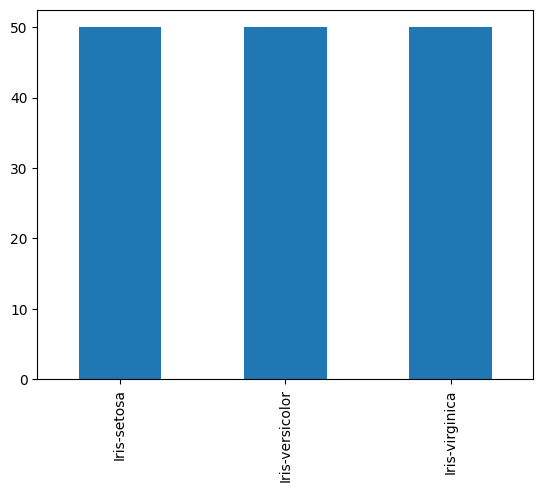

In [300]:
species.plot()

## %% [markdown]
# ### 種類カテゴリの数値変換

<Axes: >

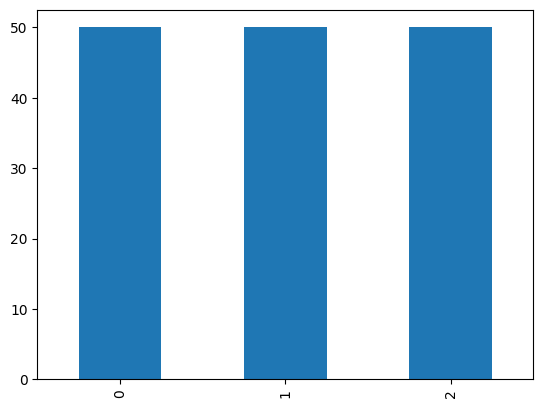

In [301]:
categorical_cols = ['species']
df_conv = convert_categoricals(df, categorical_cols)
conv_species = CategoricalData(df_conv, 'species')
conv_species.plot()

 ### ピボットテーブルによる集計

In [302]:
species.pivot('sepal_length', 'sepal_width')

species,Iris-setosa,Iris-versicolor,Iris-virginica
sepal_length,,,
0.00,NaN,NaN,1.0
0.02,1.0,NaN,NaN
0.03,3.0,NaN,NaN
0.06,1.0,NaN,NaN
0.08,4.0,NaN,NaN
0.11,2.0,NaN,NaN
0.14,5.0,NaN,NaN
0.17,4.0,1.0,1.0
0.19,8.0,2.0,NaN


In [303]:
species.pivot('sepal_width', 'petal_length')

species,Iris-setosa,Iris-versicolor,Iris-virginica
sepal_width,,,
0.00,NaN,1.0,NaN
0.08,NaN,2.0,1.0
0.13,1.0,3.0,NaN
0.17,NaN,3.0,NaN
0.21,NaN,4.0,4.0
0.25,NaN,3.0,2.0
0.29,NaN,5.0,4.0
0.33,NaN,6.0,8.0
0.38,1.0,6.0,2.0


In [304]:
species.pivot('petal_length', 'petal_width')

species,Iris-setosa,Iris-versicolor,Iris-virginica
petal_length,,,
0.01,1.0,NaN,NaN
0.02,1.0,NaN,NaN
0.04,2.0,NaN,NaN
0.06,1.0,NaN,NaN
0.07,1.0,NaN,NaN
...,...,...,...
0.88,NaN,NaN,0.0
0.89,NaN,NaN,3.0
0.92,NaN,NaN,1.0


In [305]:
species.pivot('petal_width', 'sepal_length')

species,Iris-setosa,Iris-versicolor,Iris-virginica
petal_width,,,
0.01,4.0,NaN,NaN
0.02,1.0,NaN,NaN
0.03,1.0,NaN,NaN
0.04,28.0,NaN,NaN
0.08,7.0,NaN,NaN
0.13,7.0,NaN,NaN
0.17,1.0,NaN,NaN
0.21,1.0,NaN,NaN
0.38,NaN,7.0,NaN


 ### ダミー変数化

In [306]:
df_dummy = species.dummy()
df_dummy

,sepal_length,sepal_width,petal_length,petal_width,species_Iris-setosa,species_Iris-versicolor,species_Iris-virginica
0,0.22,0.63,0.08,0.04,1,0,0
1,0.17,0.42,0.35,0.04,1,0,0
2,0.11,0.50,0.13,0.04,1,0,0
3,0.08,0.46,0.26,0.04,1,0,0
4,0.19,0.67,0.44,0.04,1,0,0
...,...,...,...,...,...,...,...
145,0.67,0.42,0.54,0.92,0,0,1
146,0.56,0.21,0.69,0.46,0,0,1
147,0.61,0.42,NaN,0.79,0,0,1
148,0.53,0.58,0.63,0.92,0,0,1


 ### データの可視化

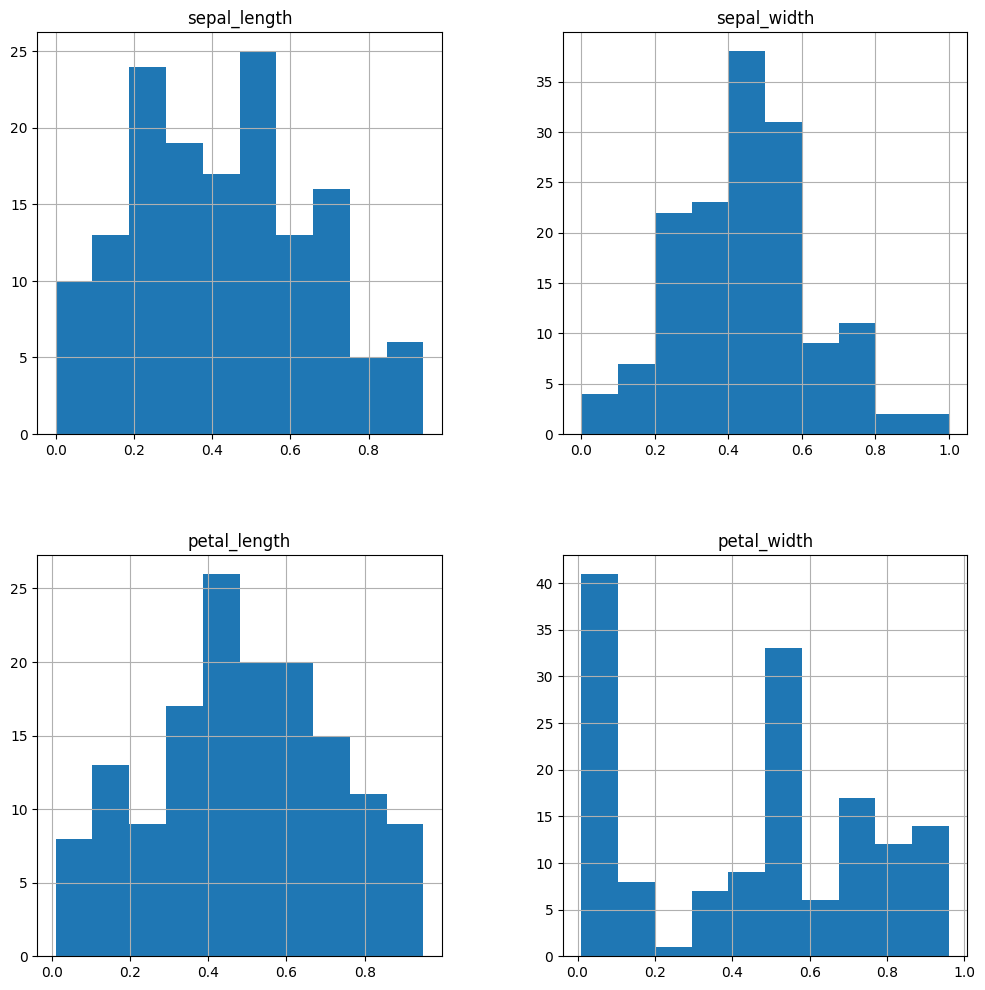

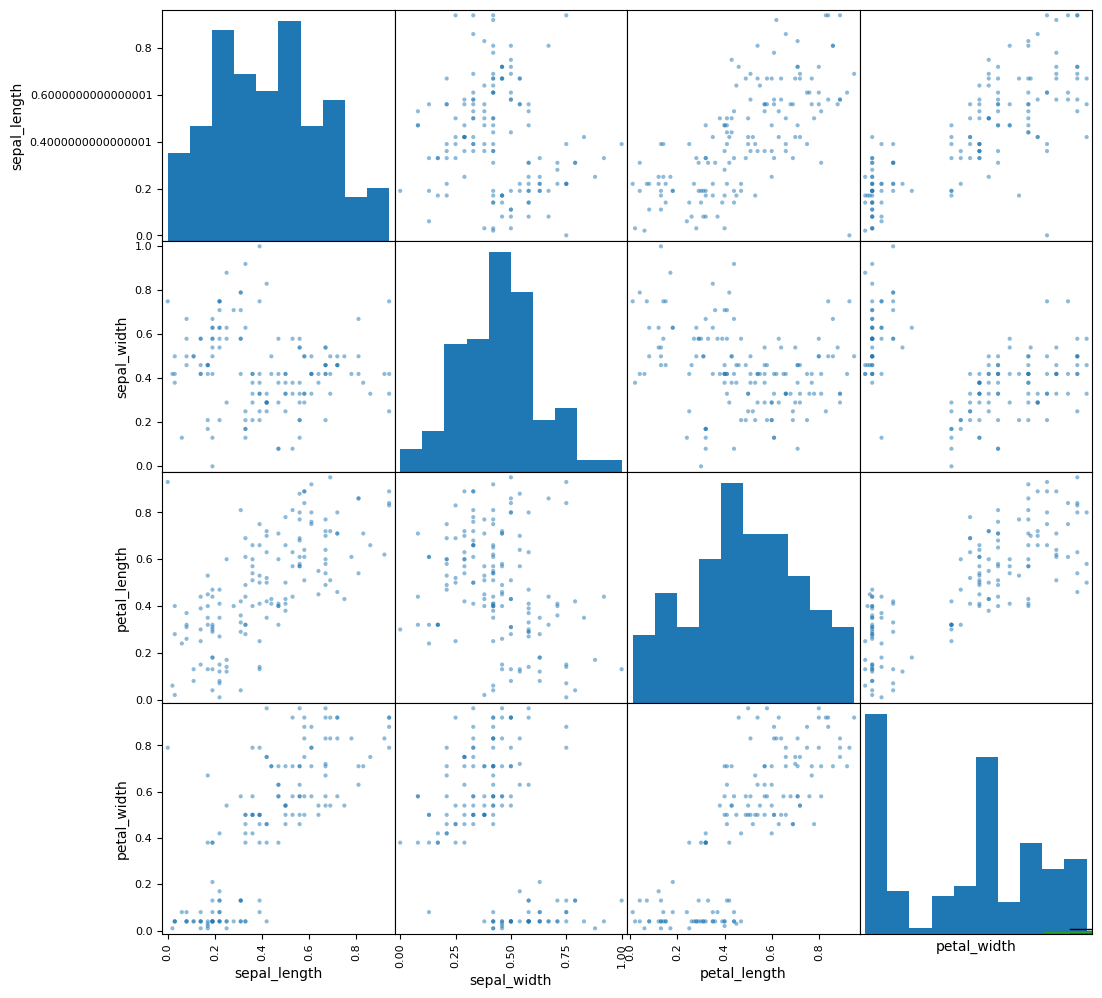

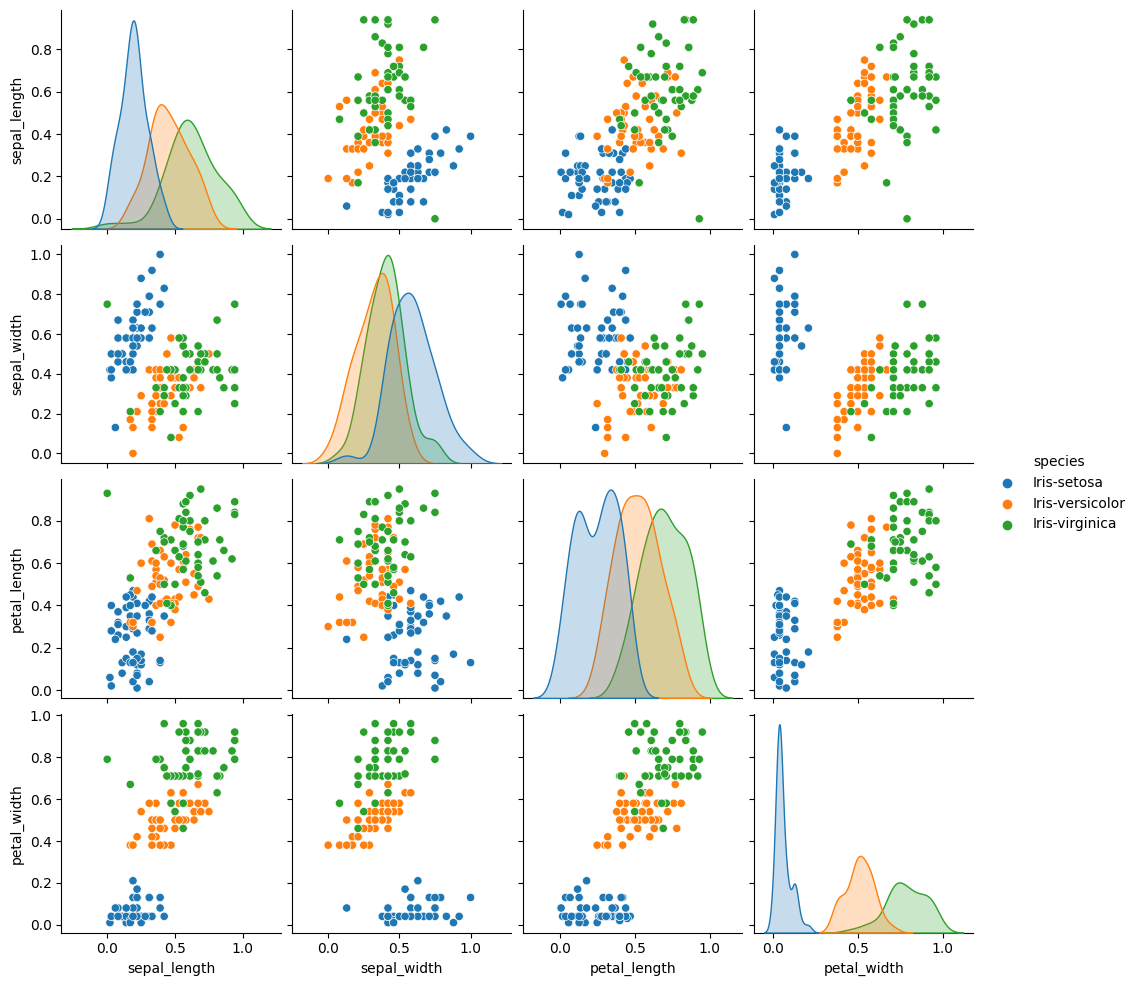

In [307]:
dv = DataVisualization(df)
dv.df_all('species')

 # 分析の実施

 ## データの前処理

 ### データの読み込み

In [308]:
repo = SQLRepository()
df = repo.get_data()
df.head(3)

,index,sepal_length,sepal_width,petal_length,petal_width,species
0,0,0.22,0.63,0.08,0.04,Iris-setosa
1,1,0.17,0.42,0.35,0.04,Iris-setosa
2,2,0.11,0.50,0.13,0.04,Iris-setosa


 ### 欠損地処理（行削除・全体代表値埋め、グループ代表値埋め）

 #### 欠損値の確認

In [309]:
df.isnull().sum()

index           0
sepal_length    2
sepal_width     1
petal_length    2
petal_width     2
species         0
dtype: int64

 #### 欠損値の削除

In [310]:
df_drop = df.dropna(how = 'any', axis = 0)
df_drop.tail(3)
df_drop.isnull().sum()

index           0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

 #### 欠損値の代表値埋め

In [311]:
df_fill = df.fillna(df.mean())
df_fill.tail(3)
df_fill.isnull().sum()

index           0
sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

 #### 特徴量と正解データの取り出し

In [312]:
xcol = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df = df_fill.copy()
x = df[xcol]
t = df['species']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.3, random_state=0)

 ### 各手法を必要に応じて実施

 - 外れ値の除外
 - 多項式特徴量・交互作用特徴量の追加
 - 特徴量の絞り込み
 - 標準化

 ## モデルの作成と学習

 ### 未学習状態モデルの生成（分類なら決定木、回帰なら線形回帰）

 #### 決定木モデルを作成する

In [313]:
from sklearn import tree
model = tree.DecisionTreeClassifier(max_depth=2, random_state=0)

 ### 訓練データで学習（必要に応じて不均衡データ補正）

 ## モデルの評価

 ### 検証データで評価し指標確認（分類なら正解率、回帰なら決定係数）

In [314]:
model.fit(x_train, y_train)
model.score(x_test, y_test)

0.9555555555555556

 ### NG:改善案検討前処理に戻る
 ### OK:最終性能評価（テストデータで評価）
 #### Take1
 - がく片の長さ、がく片の幅、花弁の長さ、花弁の幅を特徴量として、アヤメの種類を判別する。
 - 欠損データは削除する。

In [315]:
from sklearn.model_selection import train_test_split
from sklearn import tree

df_drop = df.dropna(how = 'any', axis = 0)
df_drop.tail(3)
df_drop.isnull().sum()

xcol = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
df = df_fill.copy()
x = df[xcol]
t = df['species']

x_train, x_test, y_train, y_test = train_test_split(x, t, test_size=0.3, random_state=0)

model = tree.DecisionTreeClassifier(max_depth=2, random_state=0)
model.fit(x_train, y_train)
model.score(x_test, y_test)

import pickle
with open(path + '/model/model.pkl', 'wb') as f:
    pickle.dump(model, f)

 ## 決定木における特徴量の考察

 ### 分岐条件の列を決める

In [316]:
model.tree_.feature

array([ 3, -2,  3, -2, -2], dtype=int64)

 ### 分岐条件のしきい値

In [317]:
model.tree_.threshold

array([ 0.275, -2.   ,  0.69 , -2.   , -2.   ])

 ### 末端ノードと種類の紐付け

In [318]:
print(model.tree_.value[1])
print(model.tree_.value[3])
print(model.tree_.value[4])

[[34.  0.  0.]]
[[ 0. 31.  6.]]
[[ 0.  1. 33.]]


In [319]:
model.classes_

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

 ### 決定木の可視化

[Text(0.4, 0.8333333333333334, 'petal_width <= 0.275\ngini = 0.664\nsamples = 105\nvalue = [34, 32, 39]\nclass = Iris-virginica'),
 Text(0.2, 0.5, 'gini = 0.0\nsamples = 34\nvalue = [34, 0, 0]\nclass = Iris-setosa'),
 Text(0.6, 0.5, 'petal_width <= 0.69\ngini = 0.495\nsamples = 71\nvalue = [0, 32, 39]\nclass = Iris-virginica'),
 Text(0.4, 0.16666666666666666, 'gini = 0.272\nsamples = 37\nvalue = [0, 31, 6]\nclass = Iris-versicolor'),
 Text(0.8, 0.16666666666666666, 'gini = 0.057\nsamples = 34\nvalue = [0, 1, 33]\nclass = Iris-virginica')]

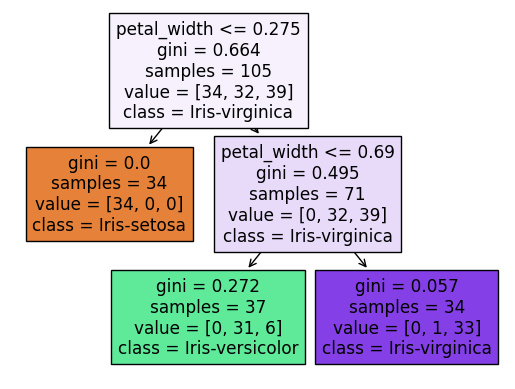

In [320]:
from sklearn.tree import plot_tree

plot_tree(model, feature_names=xcol, class_names=model.classes_, filled=True)

In [321]:
doctest.testmod(verbose=True)
unittest.main(argv=[''], verbosity=2, exit=False)

24 items had no tests:
    __main__
    __main__.CSVRepository
    __main__.CSVRepository.__init__
    __main__.CSVRepository.get_data
    __main__.CategoricalData
    __main__.CategoricalData.__init__
    __main__.CategoricalData.convert
    __main__.CategoricalData.dummy
    __main__.CategoricalData.pivot
    __main__.CategoricalData.plot
    __main__.CategoricalData.show
    __main__.DataVisualization
    __main__.DataVisualization.__init__
    __main__.DataVisualization.df_all
    __main__.DataVisualization.df_box
    __main__.DataVisualization.df_hist
    __main__.DataVisualization.df_pairplot
    __main__.DataVisualization.df_scatter
    __main__.SQLRepository
    __main__.SQLRepository.__init__
    __main__.SQLRepository.get_data
    __main__.__VSCODE_compute_hash
    __main__.__VSCODE_wrap_run_cell
    __main__.convert_categoricals
0 tests in 24 items.
0 passed and 0 failed.
Test passed.



----------------------------------------------------------------------
Ran 0 tests in 0.000s

OK
